<a href="https://colab.research.google.com/github/sjdonado/covid19-spread-forecast/blob/master/modeling_covid19_colombia_spread.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling COVID-19 Colombia spread

This is a research project with the purpose of building a model to make forecasts of the COVID-19 in Colombia.

Students:
- Oskhar Arrieta
- Juan Estrada
- Sharon Figueroa
- Brian Ramirez
- Juan Rodriguez
- Cristian Yepes

*Universidad del Norte, 2020*

# Setup

In [0]:
# Import general libs
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
DRIVE_ROOT_PATH = '/content/drive/Shared drives/data-mining/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install lmfit

# Data preparation

## Load dataset

In [0]:
# Read local data
import pandas as pd
dataset = pd.read_csv(f'{DRIVE_ROOT_PATH}dataset/Casos_positivos_de_COVID-19_en_Colombia.csv',
                      sep=',',
                      infer_datetime_format=True
                     )

# Use custom columns name
dataset.columns = [
                    'id_case', 
                    'notification_date',
                    'code', 
                    'city',
                    'department',
                    'current_status',
                    'age',
                    'sex',
                    'type',
                    'status',
                    'country_origin',
                    'fis',
                    'death_date',
                    'diagnosis_date',
                    'recover_date',
                    'web_report_date',
                    'recover_type'
                  ]

## Preprocess dataset

In [0]:
# Lowercase the current_status column. Some labels have capital letter
dataset.current_status = dataset.current_status.str.casefold()

# Merge categories into 3 (Recovered, Confirmed, Dead)
dataset.loc[
            dataset.current_status.isin(['recuperado', 'recuperado (hospital)']), 
            'current_status'
           ] = 'recovered'

dataset.loc[
            dataset.current_status.isin(['casa', 'hospital', 'hospital uci']), 
            'current_status'
           ] = 'confirmed'

dataset.loc[dataset.current_status == 'fallecido', 'current_status'] = 'dead'

# Parse dates columns into Datetime
dataset.diagnosis_date = pd.to_datetime(dataset.loc[dataset.diagnosis_date != 'SIN DATO', 'diagnosis_date'])
dataset.death_date = pd.to_datetime(dataset.loc[dataset.death_date != 'SIN DATO', 'death_date'])
dataset.recover_date = pd.to_datetime(dataset.loc[dataset.recover_date != 'SIN DATO', 'recover_date'])

## Generate time series from the current data

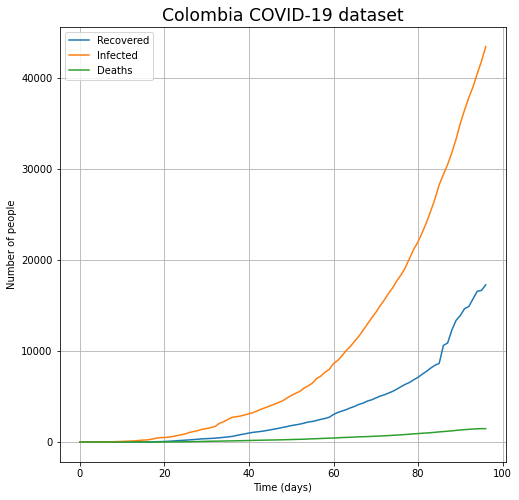

In [0]:
# Split data into arrays which represent all the possible statuses
diagnosis_dates = dataset.loc[dataset.diagnosis_date.notna(), 'diagnosis_date']
death_dates = dataset.loc[dataset.death_date.notna(), 'death_date']
recovered_dates = dataset.loc[dataset.recover_date.notna(), 'recover_date']

# Get minimum and maximun date in order to build the time range
first_date = dataset.diagnosis_date[0]
last_date = max([*diagnosis_dates, *death_dates, *recovered_dates])

total_days = (last_date - first_date).days
Recovered = []
Confirmed = []
Deaths = []

# Create the time range
Time = pd.date_range(start=first_date, end=last_date).tolist()

# Loop through the  defined time range
for date in Time:
  Recovered.append((date == recovered_dates).sum())
  Confirmed.append((date == diagnosis_dates).sum())
  Deaths.append((date == death_dates).sum())

# Plot the time series
import matplotlib.pyplot as plt
range_days = list(range(0, total_days + 1))
plt.figure(figsize=(8, 8))
plt.rcParams.update({'axes.titlesize': 'xx-large'}) 
plt.plot(range_days, np.cumsum(Recovered), label='Recovered')
plt.plot(range_days, np.cumsum(Confirmed), label='Infected')
plt.plot(range_days, np.cumsum(Deaths), label='Deaths')
plt.xlabel('Time (days)')
plt.ylabel('Number of people')
plt.legend()
plt.grid()
plt.title('Colombia COVID-19 dataset')
plt.show()

# SIR Model fiting

## Define model parameters

In [0]:
# Colombia population according to DANE (2018)
colombia_population = 48258494 

# Average virus duration in a host
avg_virus_duration = 14

# Recovery rate
gamma = 1 / avg_virus_duration

# Infection rate (Since R0 = Beta / Gamma => Beta = R0 * Gamma)
def getBeta(R0):
  return gamma * R0

## Define the model function

In [0]:
def SIR(y, t, N, beta, gamma):
  S, I, R = y
  dS = -beta * S * I / N
  dI = beta * S * I / N - gamma * I
  dR = gamma * I
  return dS, dI, dR

## Solve SIR equations system

In [0]:
# Define range time to forecast with SIR
days = 360
T = list(range(0, days))

# Define the initial conditions
I0, R0, D0 = Confirmed[0], Recovered[0], Deaths[0]
initial_condition = colombia_population - (I0 + R0 + D0), I0, R0

# Solve the ODE
from scipy.integrate import odeint
def solveSIR(beta):
  ret = odeint(SIR, initial_condition, T, args=(colombia_population, beta, gamma))
  return ret.T

## Plot SIR solution using multiple R0

**R0**: Basic reproduction number

> In Colombia 2 <= R0 <= 3 according to official articles

In [0]:
def plotSIR(S, I, R, R0):
  plt.figure(figsize=(10, 8))
  plt.rcParams.update({'axes.titlesize': 'xx-large'}) 
  plt.plot(T, S, label='Susceptible')
  plt.plot(T, I, label='Infected')
  plt.plot(T, R, label='Recovered')
  plt.xlabel('Time (days)')
  plt.ylabel('Number of people')
  plt.legend()
  plt.grid()
  plt.title(f'SIR Model - R0: {R0}')
  plt.show()

### Plot SIR with R0: 2

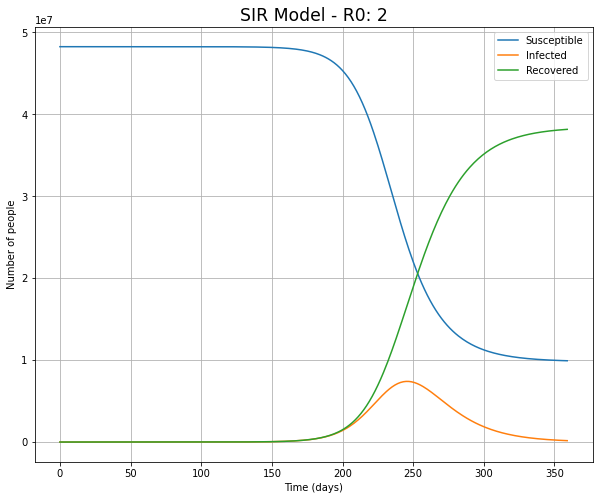

In [0]:
R0 = 2
S, I, R = solveSIR(getBeta(R0))
plotSIR(S, I, R, R0)

### Plot SIR with R0: 2.5

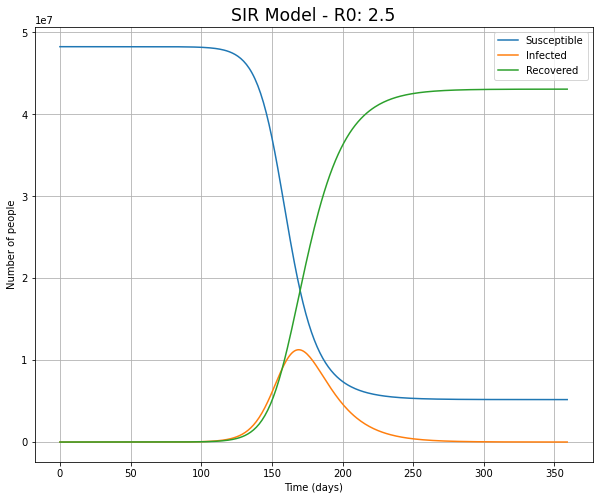

In [0]:
R0 = 2.5
S, I, R = solveSIR(getBeta(R0))
plotSIR(S, I, R, R0)

### Plot SIR with R0: 3

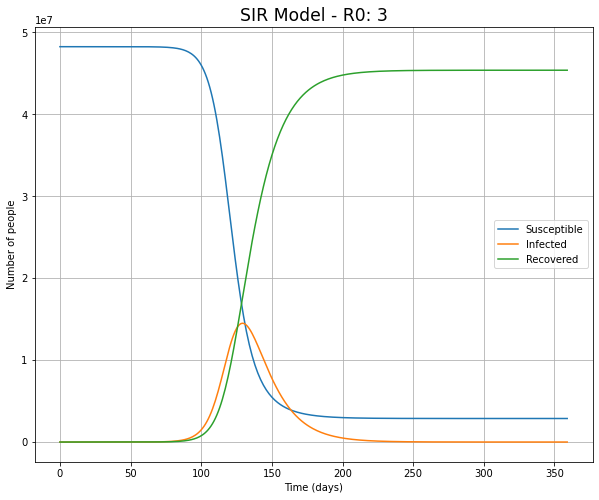

In [0]:
R0 = 3
S, I, R = solveSIR(getBeta(R0))
plotSIR(S, I, R, R0)

# Extended SIR model

Estimate Exposed and Death compartmentals - SEIRD, based on Colombia dataset

## Define model parameters

In [0]:
R0 = 3
beta = getBeta(R0)
delta = 1.0 / 5.0 # incubation period is on average 5-6 days. Source: WHO

initial_condition = colombia_population - (I0 + R0 + D0), I0, 0.0, R0, D0
params_init_min_max = {
    "alpha": (0.01, 0.02, 0.03),
    "rho": ( 1/8, 1/9, 1/10)
}

## Define the model function

In [0]:
# alpha = death rate
# rho = 1 / days from infection until death
def ODE(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

def SEIRD(alpha, rho):
  ret = odeint(ODE, initial_condition, T,
               args=(colombia_population, beta, gamma, delta, alpha, rho))
  return ret.T

In [0]:
def plotSEIRD(T, S, E, I, R, D, alpha, rho):
  plt.figure(figsize=(10, 8))
  plt.rcParams.update({'axes.titlesize': 'xx-large'}) 
  plt.plot(T, S, label='Susceptible')
  plt.plot(T, E, label='Exposed')
  plt.plot(T, I, label='Infected')
  plt.plot(T, R, label='Recovered')
  plt.plot(T, D, label='Deaths')
  plt.xlabel('Time (days)')
  plt.ylabel('Number of people')
  plt.legend()
  plt.grid()
  plt.title(f'SEIRD model - alpha {round(alpha,2)}, rho: {round(rho,3)}')
  plt.show()

## Plot SEIRD with min params

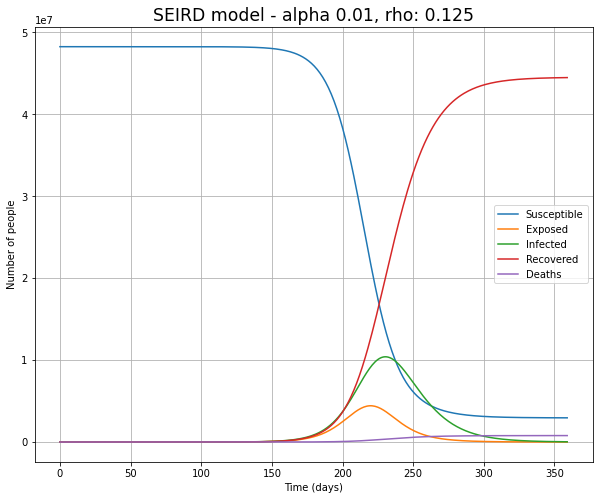

In [0]:
alpha = 0.01
rho = 1/8

S, E, I, R, D = SEIRD(alpha, rho)
plotSEIRD(T, S, E, I, R, D, alpha, rho)

## Define fitter function
We need to estimate the unknow param delta based on the real data

In [0]:
def fitter(x, alpha, rho):
    S, E, I, R, D = SEIRD(alpha, rho)
    return D[x]

In [0]:
import lmfit

mod = lmfit.Model(fitter)
for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [0]:
y_data = np.array([Confirmed, Recovered, Deaths])

days = y_data.shape[1]
x_data = np.linspace(0, days - 1, days, dtype=int)

result = mod.fit(y_data, params, method="least_squares", x=x_data)

## Plot fitting results

In [0]:
result

In [0]:
result.best_values

{'alpha': 0.029999999999999995, 'rho': 0.11111111111111109}

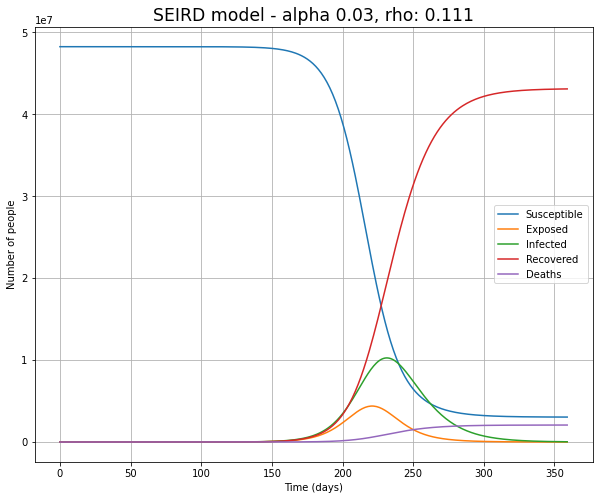

In [0]:
S, E, I, R, D = SEIRD(result.best_values['alpha'], result.best_values['rho'])

plotSEIRD(T, S, E, I, R, D, result.best_values['alpha'], result.best_values['rho'])

# Time dependency
Taking in account time events like lockdown, which reduces R0 continously

## Define model parameters

In [0]:
x0 = 19 # March 6 (first report) - March 25 (lockdown init date)

R_0_start = 5.0
k = 0.5 # R0 decline rate
R_0_end = 3.0

## Define model

In [0]:
# Now beta is a time-dependent param
def ODE(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

def SEIRD_time_dependent(T, alpha, rho):
  def logistic_R0(t):
    return (R_0_start - R_0_end) / (1 + np.exp(-k*(-t + x0))) + R_0_end

  def beta(t):
      return logistic_R0(t) * gamma

  ret = odeint(ODE, initial_condition, T,
               args=(colombia_population, beta, gamma, delta, alpha, rho))
  
  R0_over_time = [logistic_R0(i) for i in range(len(T))]
  return ret, R0_over_time

In [0]:
def plot_R0_over_time(R0_over_time, T):
  plt.figure(figsize=(10, 8))
  plt.rcParams.update({'axes.titlesize': 'xx-large'}) 
  plt.plot(T, R0_over_time, label='R0_over_time')
  plt.xlabel('Time (days)')
  plt.legend()
  plt.grid()
  plt.title(f'R0 over time')
  plt.show()

## Plot results

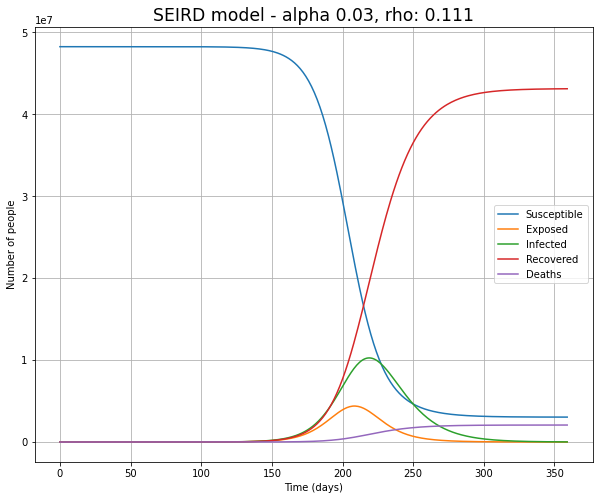

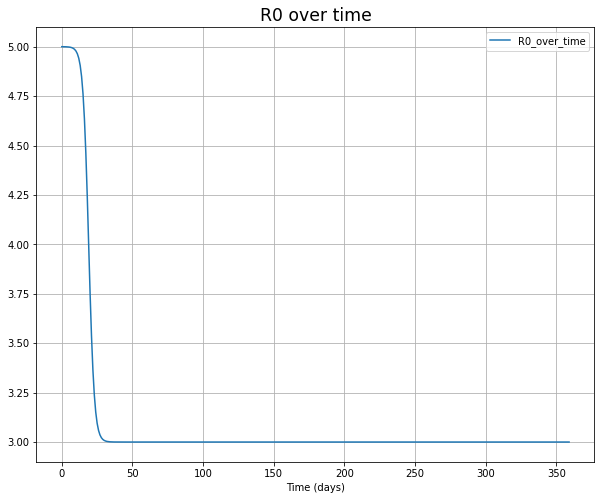

In [0]:
ret, R0_over_time = SEIRD_time_dependent(T, result.best_values['alpha'], result.best_values['rho'])
S, E, I, R, D = ret.T

plotSEIRD(T, S, E, I, R, D, result.best_values['alpha'], result.best_values['rho'])
plot_R0_over_time(R0_over_time, T)

# References

- https://www.ucm.es/icei/file/iceipapercovid12
- http://www.scielo.org.co/pdf/rsap/v22n1/0124-0064-rsap-22-01-e185977.pdf
- http://revistaendocrino.org/index.php/rcedm/article/view/572/755
- https://coronaviruscolombia.gov.co/Covid19/index.html
- https://towardsdatascience.com/infectious-disease-modelling-beyond-the-basic-sir-model-216369c584c4
- https://towardsdatascience.com/infectious-disease-modelling-part-i-understanding-sir-28d60e29fdfc